In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.io import arff
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = arff.loadarff(r"electricity-normalized.arff")
df = pd.DataFrame(data[0])
df.shape

FileNotFoundError: ignored

In [71]:
data = arff.loadarff('/content/drive/MyDrive/ECS_171_Files/ECS171/electricity-normalized.arff')
df = pd.DataFrame(data[0])



##Data Preprocessing

In [72]:
df['class'] = df['class'].str.decode('utf-8') # remove byte string prefix
df['class'] = df['class'].replace({'UP': 1, 'DOWN': 0})
df.dropna(inplace=True)
# Encoding 'day' column
df['day'] = df['day'].map({b'1': 1, b'2': 2, b'3': 3, b'4': 4, b'5': 5, b'6': 6, b'7': 7})

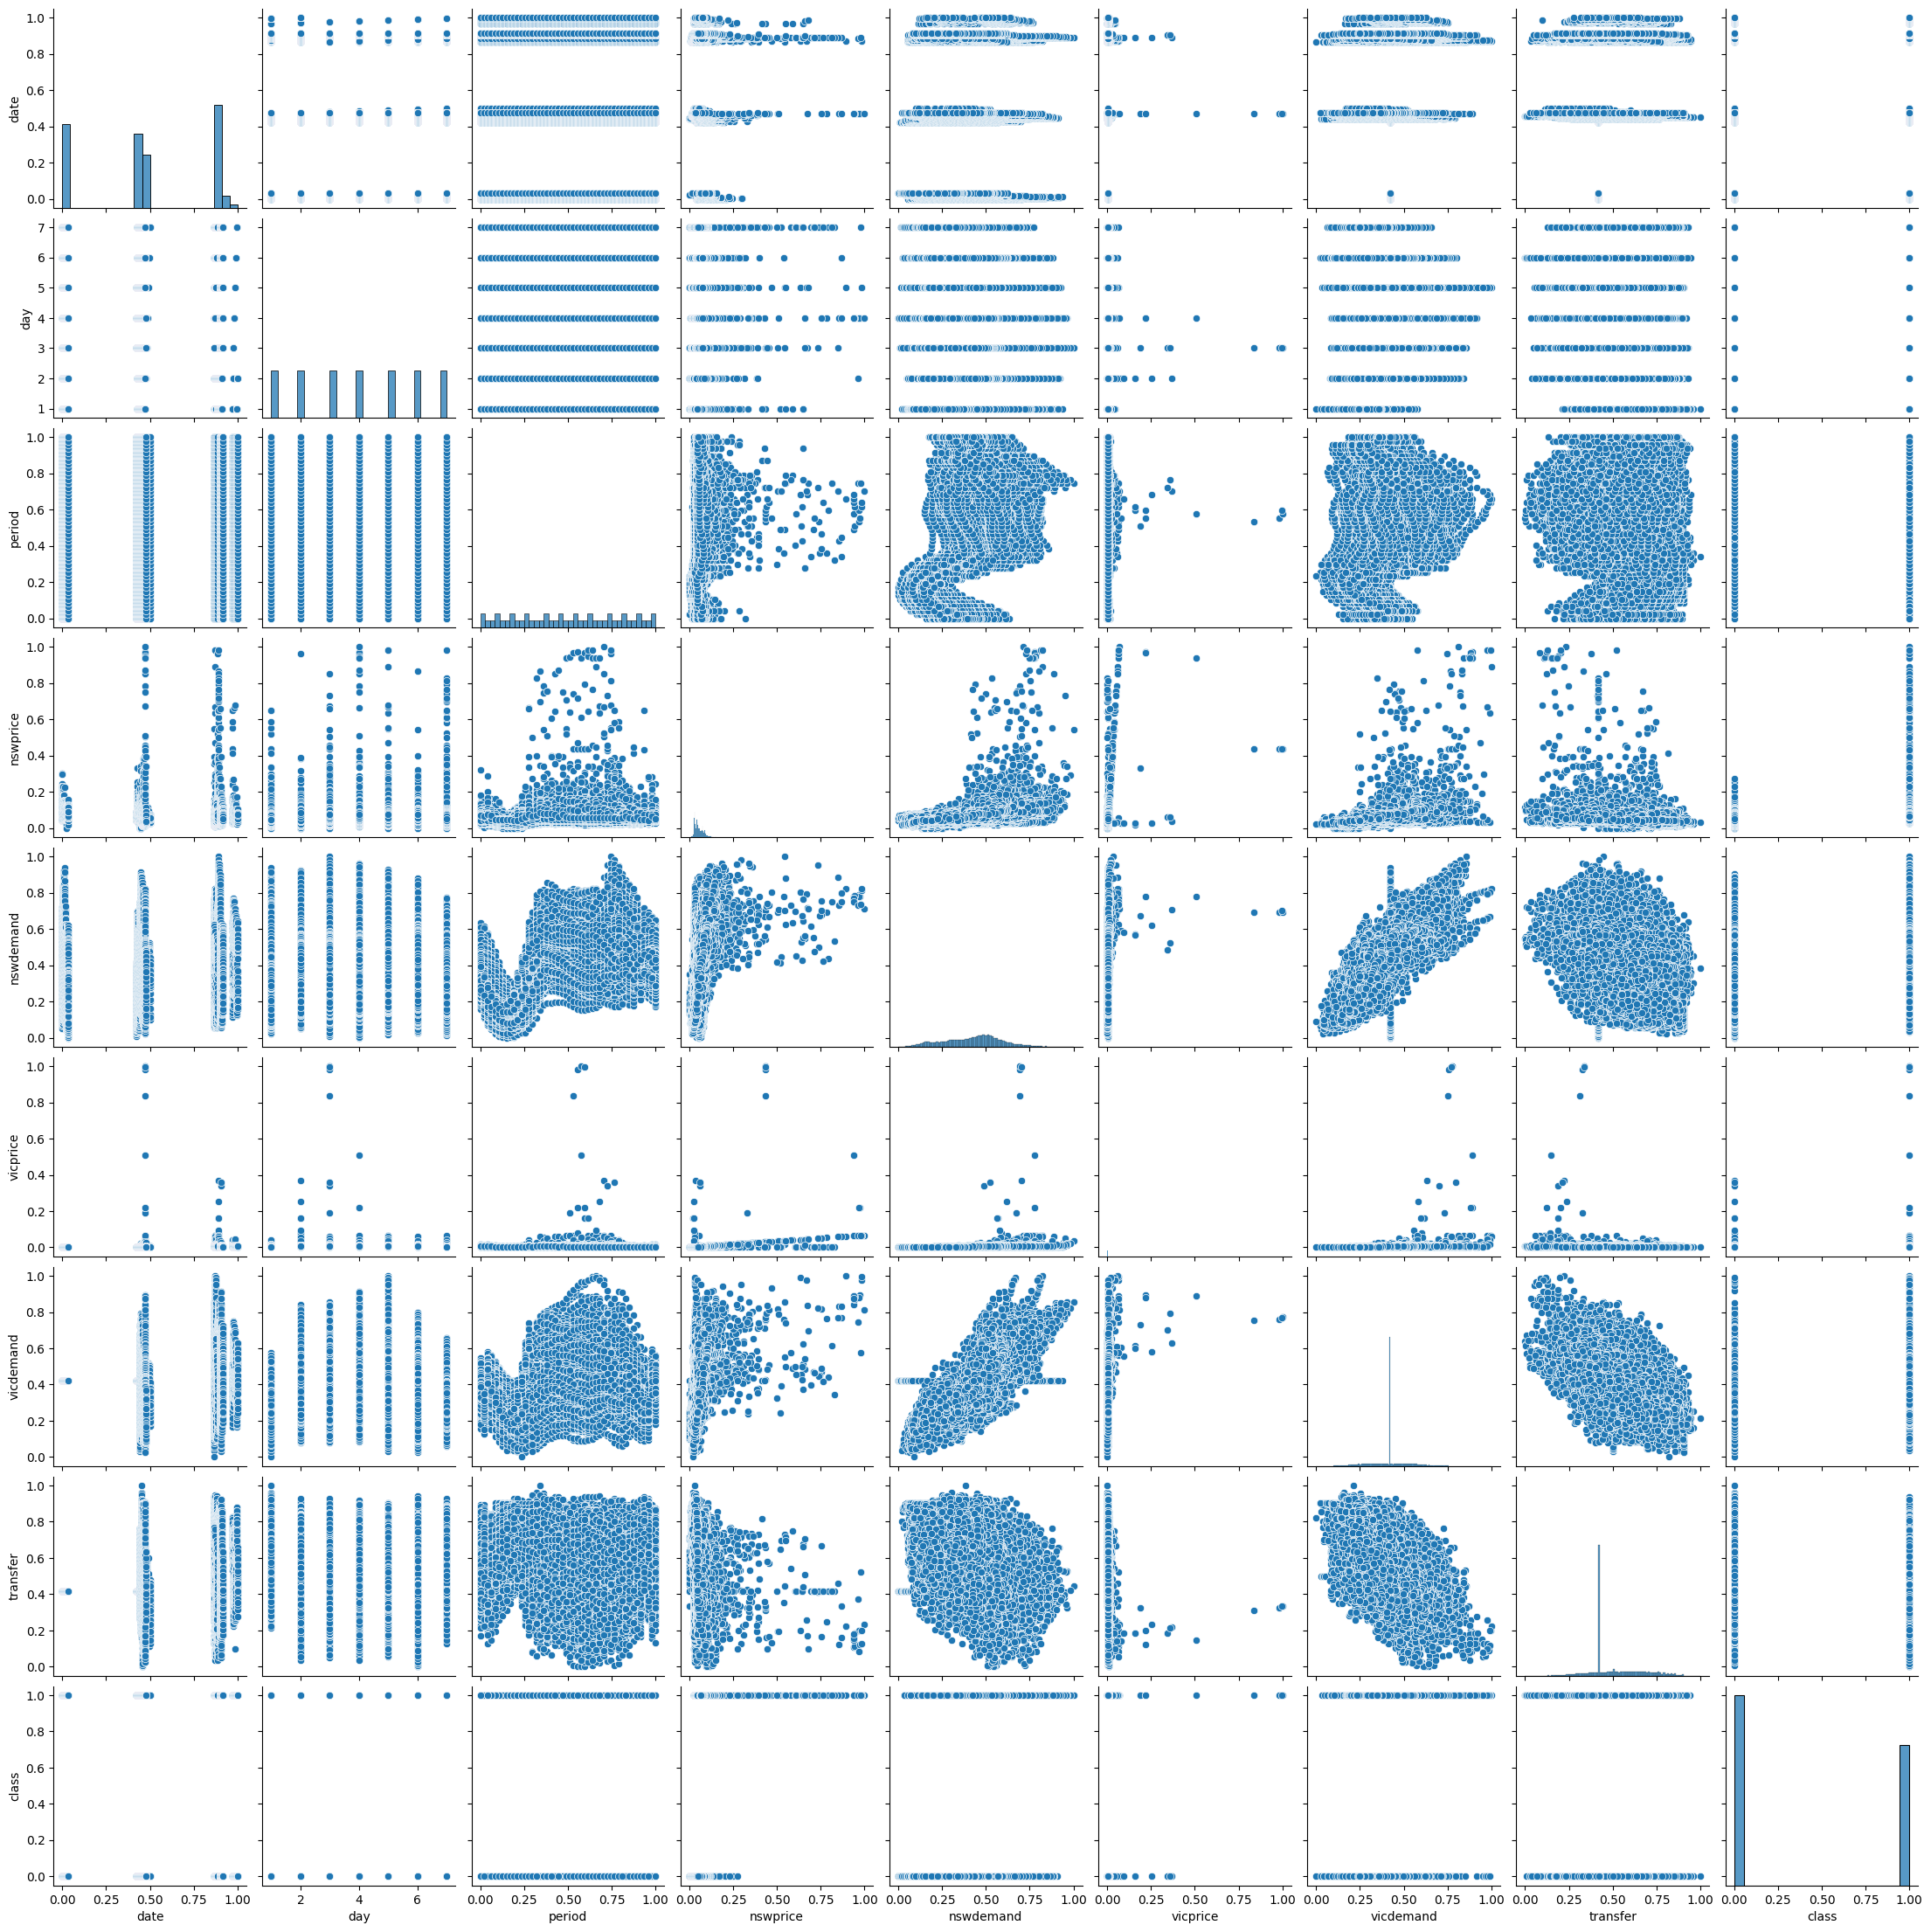

In [69]:
sns.pairplot(df)
plt.show()

In [73]:
from datetime import datetime
import time

# Define the date format
fmt = '%d %B %Y'

# Convert the start and end dates to timestamps
start_date = time.mktime(datetime.strptime('7 May 1996', fmt).timetuple())
end_date = time.mktime(datetime.strptime('5 December 1998', fmt).timetuple())

# Denormalize the 'date' column
df['denormalized_date'] = df['date'] * (end_date - start_date) + start_date
df['denormalized_date'] = pd.to_datetime(df['denormalized_date'], unit='s')



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


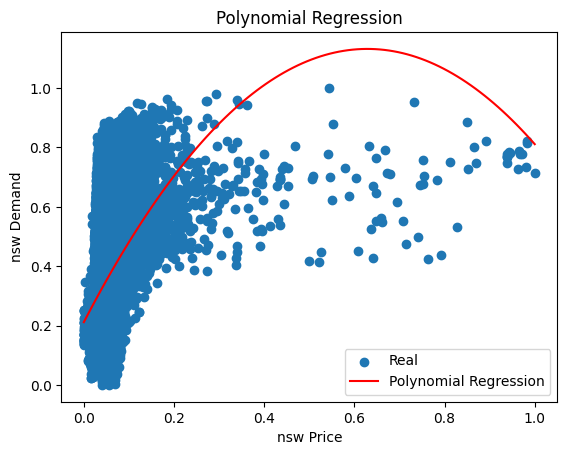

In [74]:

# Define the features and target variable
X = df[['day', 'nswprice', 'date']]
y = df['nswdemand']

#poly features
degree = 2  # degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

# Fit model
poly_regression_model = LinearRegression()
poly_regression_model.fit(X_poly, y)

X_line = np.linspace(X['nswprice'].min(), X['nswprice'].max(), 100).reshape(-1, 1)
X_line_poly = poly_features.transform(np.hstack([np.ones_like(X_line), X_line, np.ones_like(X_line)]))
y_line_pred = poly_regression_model.predict(X_line_poly)

# Plot the real values
plt.scatter(X['nswprice'], y, label='Real')

plt.plot(X_line, y_line_pred, color='red', label='Polynomial Regression')

plt.xlabel('nsw Price')
plt.ylabel('nsw Demand')
plt.title('Polynomial Regression')
plt.legend()
plt.show()


Accuracy: 0.6361028357056162
Confusion Matrix:
[[3909 1282]
 [2016 1856]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


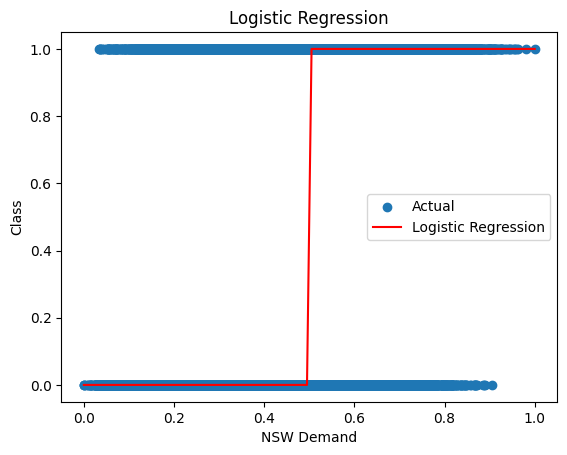

In [75]:

X = df[['nswdemand']]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

X_boundary = np.linspace(X['nswdemand'].min(), X['nswdemand'].max(), 100).reshape(-1, 1)
y_boundary_pred = logistic_regression_model.predict(X_boundary)

plt.scatter(X['nswdemand'], y, label='Actual')
plt.plot(X_boundary, y_boundary_pred, color='red', label='Logistic Regression')
plt.xlabel('NSW Demand')
plt.ylabel('Class')
plt.title('Logistic Regression')
plt.legend()
plt.show()

Epoch 1/3
37/37 [==============================] - 24s 532ms/step - loss: 0.0485
Epoch 2/3
37/37 [==============================] - 18s 485ms/step - loss: 0.0153
Epoch 3/3
9015/9015 [==============================] - 81s 9ms/step


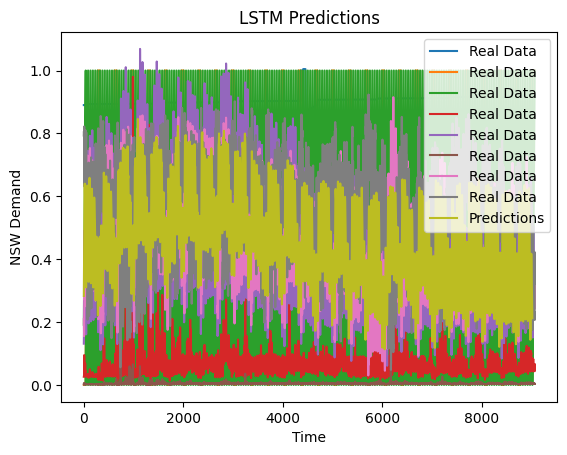

In [76]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


step_num = 48
features = ['date','day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']

def lstm_model(features, target):
    # Split data
    train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

    # Normalize
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data[features])
    test_data_scaled = scaler.transform(test_data[features])

    # training data using TimeSeriesGenerator
    train_generator = TimeseriesGenerator(train_data_scaled, train_data_scaled[:, features.index(target)],
                                          length=step_num, batch_size=1000)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(step_num, len(features))))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_generator, epochs=3)

    test_generator = TimeseriesGenerator(test_data_scaled, test_data_scaled[:, features.index(target)],
                                         length=step_num, batch_size=1)

    predictions = model.predict(test_generator)
    predictions = predictions[:len(test_data)]

    # Denormalize only the 'nswdemand' column
   # predictions = scaler.inverse_transform(predictions.reshape(-1, 1))[:, 0]
    #test_data_denormalized = scaler.inverse_transform(test_data_scaled[:, features.index(target)].reshape(-1, 1))[:, 0]

    # Plot the predictions
    plt.plot(test_data_scaled, label='Real Data')
    plt.plot(predictions, label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('NSW Demand')
    plt.title('LSTM Predictions')
    plt.legend()
    plt.show()
lstm_model(features, 'nswdemand')